In [1]:
import torch
import torch.nn as nn

# In order to compare with the results of WGAN, DCGAN is trained here

In [2]:
class Discriminator(nn.Module):
    
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()
        self.feature_dim = features
        self.conv_block = nn.Sequential(
            nn.Conv2d(image_channels, features, 5, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            
            nn.Conv2d(features, features*2, 5, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*2, features*4, 5, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*4, features*8, 5, 2, 1),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Linear(features*8, 1)
        
    def forward(self, x):   
        x = self.conv_block(x)
        x = x.view(-1, self.feature_dim*8)
        x = self.fc(x)
        x = nn.Sigmoid()(x)
        return x

In [3]:
class Generator(nn.Module):
        
    def __init__(self, z_dim, img_channel, features):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # tensor z has dimension: N * z_dim * 1 * 1 ---> N * features * 16 * 4 * 4 
            nn.ConvTranspose2d(z_dim, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(features*4, img_channel, kernel_size=4, stride=2, padding=1), # 32x32
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.gen(x)
        

In [4]:
import torch
import torch.nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
LR = 2e-4
BATCH_SIZE = 4
IMAGE_SIZE = 32
IMG_CHANNEL = 3
Z_DIM = 100
NUM_EPOCHS = 3000
FEATURES_DISC = 64
FEATURES_GEN = 64

my_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

#dataset = datasets.MNIST(root='./', train=True, download=True, transform=my_transforms)
dataset = datasets.ImageFolder(root='./robot-face/', transform=my_transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, IMG_CHANNEL, FEATURES_GEN).to(device)
disc = Discriminator(IMG_CHANNEL, FEATURES_DISC).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LR)
opt_disc = torch.optim.Adam(disc.parameters(), lr=LR)

criterion = nn.BCELoss()

fixed_noise = torch.randn(4, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"./runs/robot_1/real")
writer_fake = SummaryWriter(f'./runs/robot_1/fake')
step = 0

In [5]:
gen_state = torch.load('./gen.pt')
gen.load_state_dict(gen_state)

<All keys matched successfully>

In [23]:
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        # train discriminator
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_fake + loss_disc_real) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        # train generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        if batch_idx == 0 :
            print(f"Epoch[{epoch}/{NUM_EPOCHS} Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}]")

        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 3, 32, 32)
            data = real.reshape(-1, 3, 32, 32)
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(real, normalize=True)

            writer_fake.add_image(
                "./runs/robot_1/real", img_grid_fake, global_step=step
            )

            writer_real.add_image(
                "./runs/robot_1/fake", img_grid_real, global_step=step
            )
            step += 1

Epoch[0/3000 Loss D: 0.6934, Loss G: 0.6944]
Epoch[1/3000 Loss D: 0.1187, Loss G: 2.7776]
Epoch[2/3000 Loss D: 0.0181, Loss G: 3.5023]
Epoch[3/3000 Loss D: 0.0067, Loss G: 4.9220]
Epoch[4/3000 Loss D: 0.3848, Loss G: 8.2918]
Epoch[5/3000 Loss D: 0.0375, Loss G: 2.3147]
Epoch[6/3000 Loss D: 0.1591, Loss G: 3.4542]
Epoch[7/3000 Loss D: 0.0168, Loss G: 4.8484]
Epoch[8/3000 Loss D: 0.0105, Loss G: 13.0582]
Epoch[9/3000 Loss D: 0.0036, Loss G: 7.5375]
Epoch[10/3000 Loss D: 0.2166, Loss G: 3.0071]
Epoch[11/3000 Loss D: 0.1182, Loss G: 7.0233]
Epoch[12/3000 Loss D: 0.6085, Loss G: 5.3152]
Epoch[13/3000 Loss D: 0.2241, Loss G: 1.3745]
Epoch[14/3000 Loss D: 0.2314, Loss G: 2.4162]
Epoch[15/3000 Loss D: 0.1649, Loss G: 2.7538]
Epoch[16/3000 Loss D: 0.8318, Loss G: 1.2410]
Epoch[17/3000 Loss D: 0.0610, Loss G: 4.1510]
Epoch[18/3000 Loss D: 1.1408, Loss G: 2.8677]
Epoch[19/3000 Loss D: 0.0033, Loss G: 5.0307]
Epoch[20/3000 Loss D: 0.0085, Loss G: 4.9330]
Epoch[21/3000 Loss D: 1.7351, Loss G: 0.306

Epoch[177/3000 Loss D: 0.0512, Loss G: 3.1886]
Epoch[178/3000 Loss D: 0.0138, Loss G: 4.0022]
Epoch[179/3000 Loss D: 0.1541, Loss G: 4.7586]
Epoch[180/3000 Loss D: 0.1264, Loss G: 2.0294]
Epoch[181/3000 Loss D: 0.1044, Loss G: 3.2611]
Epoch[182/3000 Loss D: 0.5095, Loss G: 0.9211]
Epoch[183/3000 Loss D: 0.2988, Loss G: 2.2504]
Epoch[184/3000 Loss D: 0.5234, Loss G: 1.7567]
Epoch[185/3000 Loss D: 0.0577, Loss G: 4.3792]
Epoch[186/3000 Loss D: 0.5152, Loss G: 4.1339]
Epoch[187/3000 Loss D: 0.1404, Loss G: 1.7483]
Epoch[188/3000 Loss D: 0.1288, Loss G: 3.9731]
Epoch[189/3000 Loss D: 0.0766, Loss G: 2.4336]
Epoch[190/3000 Loss D: 0.3279, Loss G: 2.1619]
Epoch[191/3000 Loss D: 0.2546, Loss G: 4.1879]
Epoch[192/3000 Loss D: 0.1413, Loss G: 1.9069]
Epoch[193/3000 Loss D: 0.0514, Loss G: 3.7393]
Epoch[194/3000 Loss D: 0.2056, Loss G: 1.6754]
Epoch[195/3000 Loss D: 0.2407, Loss G: 2.0871]
Epoch[196/3000 Loss D: 0.0743, Loss G: 2.4126]
Epoch[197/3000 Loss D: 0.5153, Loss G: 2.8306]
Epoch[198/300

Epoch[352/3000 Loss D: 0.0108, Loss G: 7.9113]
Epoch[353/3000 Loss D: 0.0025, Loss G: 6.1421]
Epoch[354/3000 Loss D: 0.0108, Loss G: 6.0540]
Epoch[355/3000 Loss D: 0.0081, Loss G: 5.4866]
Epoch[356/3000 Loss D: 0.0102, Loss G: 5.8870]
Epoch[357/3000 Loss D: 0.0309, Loss G: 4.8610]
Epoch[358/3000 Loss D: 0.0075, Loss G: 5.2454]
Epoch[359/3000 Loss D: 0.0024, Loss G: 6.6904]
Epoch[360/3000 Loss D: 0.0427, Loss G: 5.4891]
Epoch[361/3000 Loss D: 0.0751, Loss G: 4.6404]
Epoch[362/3000 Loss D: 0.0157, Loss G: 4.8775]
Epoch[363/3000 Loss D: 0.1533, Loss G: 7.5324]
Epoch[364/3000 Loss D: 0.0053, Loss G: 8.0976]
Epoch[365/3000 Loss D: 0.2017, Loss G: 4.3302]
Epoch[366/3000 Loss D: 0.1643, Loss G: 2.3581]
Epoch[367/3000 Loss D: 0.0109, Loss G: 4.5836]
Epoch[368/3000 Loss D: 0.0672, Loss G: 2.9478]
Epoch[369/3000 Loss D: 0.0037, Loss G: 5.6542]
Epoch[370/3000 Loss D: 0.0021, Loss G: 6.3883]
Epoch[371/3000 Loss D: 0.0390, Loss G: 4.4714]
Epoch[372/3000 Loss D: 0.0036, Loss G: 6.5817]
Epoch[373/300

Epoch[527/3000 Loss D: 0.0282, Loss G: 4.2899]
Epoch[528/3000 Loss D: 0.0266, Loss G: 3.1197]
Epoch[529/3000 Loss D: 0.0252, Loss G: 4.8135]
Epoch[530/3000 Loss D: 0.0898, Loss G: 3.8675]
Epoch[531/3000 Loss D: 0.4667, Loss G: 3.4001]
Epoch[532/3000 Loss D: 0.1272, Loss G: 3.2261]
Epoch[533/3000 Loss D: 0.9084, Loss G: 8.2551]
Epoch[534/3000 Loss D: 0.2756, Loss G: 3.9101]
Epoch[535/3000 Loss D: 0.0077, Loss G: 5.5280]
Epoch[536/3000 Loss D: 0.4812, Loss G: 5.2918]
Epoch[537/3000 Loss D: 0.7295, Loss G: 13.4156]
Epoch[538/3000 Loss D: 0.0106, Loss G: 5.6507]
Epoch[539/3000 Loss D: 0.0146, Loss G: 6.4136]
Epoch[540/3000 Loss D: 0.0024, Loss G: 6.9153]
Epoch[541/3000 Loss D: 0.1053, Loss G: 2.6913]
Epoch[542/3000 Loss D: 0.0188, Loss G: 3.7811]
Epoch[543/3000 Loss D: 0.4174, Loss G: 3.7501]
Epoch[544/3000 Loss D: 0.3853, Loss G: 4.0084]
Epoch[545/3000 Loss D: 0.1688, Loss G: 2.9939]
Epoch[546/3000 Loss D: 0.1437, Loss G: 4.6693]
Epoch[547/3000 Loss D: 0.0684, Loss G: 5.1958]
Epoch[548/30

Epoch[702/3000 Loss D: 0.0786, Loss G: 1.9336]
Epoch[703/3000 Loss D: 0.2987, Loss G: 2.8579]
Epoch[704/3000 Loss D: 0.0215, Loss G: 3.9520]
Epoch[705/3000 Loss D: 0.0022, Loss G: 5.8330]
Epoch[706/3000 Loss D: 0.0310, Loss G: 7.3859]
Epoch[707/3000 Loss D: 0.0244, Loss G: 4.2416]
Epoch[708/3000 Loss D: 0.4244, Loss G: 5.7542]
Epoch[709/3000 Loss D: 0.0005, Loss G: 7.5715]
Epoch[710/3000 Loss D: 0.0164, Loss G: 4.9762]
Epoch[711/3000 Loss D: 0.0010, Loss G: 8.0141]
Epoch[712/3000 Loss D: 0.0017, Loss G: 7.6737]
Epoch[713/3000 Loss D: 0.0094, Loss G: 5.9774]
Epoch[714/3000 Loss D: 0.0001, Loss G: 12.1411]
Epoch[715/3000 Loss D: 0.1529, Loss G: 6.6108]
Epoch[716/3000 Loss D: 0.0006, Loss G: 7.0917]
Epoch[717/3000 Loss D: 0.0009, Loss G: 7.8704]
Epoch[718/3000 Loss D: 0.0001, Loss G: 8.8582]
Epoch[719/3000 Loss D: 0.0001, Loss G: 8.5492]
Epoch[720/3000 Loss D: 0.0076, Loss G: 5.9103]
Epoch[721/3000 Loss D: 0.0012, Loss G: 6.6334]
Epoch[722/3000 Loss D: 0.0191, Loss G: 3.8283]
Epoch[723/30

Epoch[877/3000 Loss D: 0.0049, Loss G: 4.7196]
Epoch[878/3000 Loss D: 0.0073, Loss G: 4.2933]
Epoch[879/3000 Loss D: 0.0078, Loss G: 4.2567]
Epoch[880/3000 Loss D: 0.0027, Loss G: 4.9663]
Epoch[881/3000 Loss D: 0.0142, Loss G: 3.7278]
Epoch[882/3000 Loss D: 0.0048, Loss G: 4.7529]
Epoch[883/3000 Loss D: 0.0052, Loss G: 4.6782]
Epoch[884/3000 Loss D: 0.5669, Loss G: 4.0872]
Epoch[885/3000 Loss D: 0.0056, Loss G: 4.6544]
Epoch[886/3000 Loss D: 0.0039, Loss G: 4.8415]
Epoch[887/3000 Loss D: 0.4870, Loss G: 3.6863]
Epoch[888/3000 Loss D: 0.0036, Loss G: 5.0991]
Epoch[889/3000 Loss D: 0.0093, Loss G: 3.9543]
Epoch[890/3000 Loss D: 0.0102, Loss G: 4.0173]
Epoch[891/3000 Loss D: 0.0070, Loss G: 4.3004]
Epoch[892/3000 Loss D: 0.0059, Loss G: 4.3489]
Epoch[893/3000 Loss D: 0.0095, Loss G: 3.9069]
Epoch[894/3000 Loss D: 0.0063, Loss G: 4.2734]
Epoch[895/3000 Loss D: 0.0087, Loss G: 3.9963]
Epoch[896/3000 Loss D: 0.0078, Loss G: 4.0899]
Epoch[897/3000 Loss D: 0.0087, Loss G: 4.0198]
Epoch[898/300

Epoch[1050/3000 Loss D: 0.0000, Loss G: 10.7874]
Epoch[1051/3000 Loss D: 0.0020, Loss G: 6.8849]
Epoch[1052/3000 Loss D: 0.0180, Loss G: 5.4050]
Epoch[1053/3000 Loss D: 0.0475, Loss G: 4.9826]
Epoch[1054/3000 Loss D: 0.0071, Loss G: 6.3782]
Epoch[1055/3000 Loss D: 0.0087, Loss G: 5.1795]
Epoch[1056/3000 Loss D: 0.0986, Loss G: 11.3229]
Epoch[1057/3000 Loss D: 0.0037, Loss G: 6.6704]
Epoch[1058/3000 Loss D: 0.0028, Loss G: 6.1370]
Epoch[1059/3000 Loss D: 0.0003, Loss G: 9.1185]
Epoch[1060/3000 Loss D: 0.0084, Loss G: 5.5211]
Epoch[1061/3000 Loss D: 0.0095, Loss G: 4.8317]
Epoch[1062/3000 Loss D: 0.0004, Loss G: 8.1109]
Epoch[1063/3000 Loss D: 0.0041, Loss G: 6.4078]
Epoch[1064/3000 Loss D: 0.0012, Loss G: 6.3528]
Epoch[1065/3000 Loss D: 0.0169, Loss G: 5.2880]
Epoch[1066/3000 Loss D: 0.0004, Loss G: 7.0482]
Epoch[1067/3000 Loss D: 0.0369, Loss G: 3.7959]
Epoch[1068/3000 Loss D: 0.0074, Loss G: 6.5348]
Epoch[1069/3000 Loss D: 0.0067, Loss G: 7.8079]
Epoch[1070/3000 Loss D: 0.0043, Loss G

Epoch[1220/3000 Loss D: 0.1457, Loss G: 6.4110]
Epoch[1221/3000 Loss D: 0.0000, Loss G: 11.3594]
Epoch[1222/3000 Loss D: 0.0041, Loss G: 6.3197]
Epoch[1223/3000 Loss D: 0.0001, Loss G: 9.0354]
Epoch[1224/3000 Loss D: 0.0005, Loss G: 8.0744]
Epoch[1225/3000 Loss D: 0.0047, Loss G: 5.9761]
Epoch[1226/3000 Loss D: 0.0024, Loss G: 8.1085]
Epoch[1227/3000 Loss D: 0.0001, Loss G: 9.6170]
Epoch[1228/3000 Loss D: 0.6154, Loss G: 23.8458]
Epoch[1229/3000 Loss D: 0.0000, Loss G: 9.7472]
Epoch[1230/3000 Loss D: 0.0004, Loss G: 7.8539]
Epoch[1231/3000 Loss D: 0.0067, Loss G: 6.0792]
Epoch[1232/3000 Loss D: 0.0072, Loss G: 6.2542]
Epoch[1233/3000 Loss D: 0.0052, Loss G: 6.1832]
Epoch[1234/3000 Loss D: 0.0045, Loss G: 6.2860]
Epoch[1235/3000 Loss D: 0.0007, Loss G: 8.0143]
Epoch[1236/3000 Loss D: 0.0031, Loss G: 6.4432]
Epoch[1237/3000 Loss D: 0.0001, Loss G: 4.7766]
Epoch[1238/3000 Loss D: 0.0000, Loss G: 29.9564]
Epoch[1239/3000 Loss D: 0.0010, Loss G: 7.1768]
Epoch[1240/3000 Loss D: 1.3188, Loss 

Epoch[1391/3000 Loss D: 0.0003, Loss G: 8.0288]
Epoch[1392/3000 Loss D: 0.0001, Loss G: 11.2823]
Epoch[1393/3000 Loss D: 0.0019, Loss G: 6.5215]
Epoch[1394/3000 Loss D: 0.0038, Loss G: 5.6020]
Epoch[1395/3000 Loss D: 0.0455, Loss G: 3.4474]
Epoch[1396/3000 Loss D: 0.0014, Loss G: 6.2287]
Epoch[1397/3000 Loss D: 0.0003, Loss G: 8.4557]
Epoch[1398/3000 Loss D: 0.0004, Loss G: 3.8084]
Epoch[1399/3000 Loss D: 0.0085, Loss G: 3.8232]
Epoch[1400/3000 Loss D: 0.0062, Loss G: 4.7996]
Epoch[1401/3000 Loss D: 0.0371, Loss G: 4.6854]
Epoch[1402/3000 Loss D: 0.0014, Loss G: 6.6617]
Epoch[1403/3000 Loss D: 0.0012, Loss G: 6.2459]
Epoch[1404/3000 Loss D: 0.0029, Loss G: 5.3728]
Epoch[1405/3000 Loss D: 0.0129, Loss G: 4.2684]
Epoch[1406/3000 Loss D: 0.5407, Loss G: 4.9114]
Epoch[1407/3000 Loss D: 0.0157, Loss G: 3.8108]
Epoch[1408/3000 Loss D: 0.0114, Loss G: 3.9620]
Epoch[1409/3000 Loss D: 0.0033, Loss G: 5.2431]
Epoch[1410/3000 Loss D: 0.0021, Loss G: 6.2375]
Epoch[1411/3000 Loss D: 0.0029, Loss G:

Epoch[1562/3000 Loss D: 0.0041, Loss G: 4.8845]
Epoch[1563/3000 Loss D: 0.0035, Loss G: 4.8265]
Epoch[1564/3000 Loss D: 0.0112, Loss G: 3.8121]
Epoch[1565/3000 Loss D: 0.5835, Loss G: 4.4524]
Epoch[1566/3000 Loss D: 0.0041, Loss G: 4.9114]
Epoch[1567/3000 Loss D: 0.0051, Loss G: 4.4831]
Epoch[1568/3000 Loss D: 0.0117, Loss G: 3.7721]
Epoch[1569/3000 Loss D: 0.0056, Loss G: 4.6406]
Epoch[1570/3000 Loss D: 0.0052, Loss G: 4.5226]
Epoch[1571/3000 Loss D: 0.0050, Loss G: 4.4704]
Epoch[1572/3000 Loss D: 0.0127, Loss G: 3.7726]
Epoch[1573/3000 Loss D: 0.0069, Loss G: 4.2679]
Epoch[1574/3000 Loss D: 0.0079, Loss G: 4.2797]
Epoch[1575/3000 Loss D: 0.0069, Loss G: 4.3104]
Epoch[1576/3000 Loss D: 0.0056, Loss G: 4.4170]
Epoch[1577/3000 Loss D: 0.0087, Loss G: 4.0025]
Epoch[1578/3000 Loss D: 0.0100, Loss G: 3.9656]
Epoch[1579/3000 Loss D: 0.0086, Loss G: 4.0743]
Epoch[1580/3000 Loss D: 0.0087, Loss G: 4.0460]
Epoch[1581/3000 Loss D: 0.0064, Loss G: 4.4985]
Epoch[1582/3000 Loss D: 0.0074, Loss G: 

Epoch[1733/3000 Loss D: 0.0487, Loss G: 2.7302]
Epoch[1734/3000 Loss D: 0.0002, Loss G: 8.2716]
Epoch[1735/3000 Loss D: 0.0001, Loss G: 8.9409]
Epoch[1736/3000 Loss D: 0.0147, Loss G: 7.8316]
Epoch[1737/3000 Loss D: 0.0003, Loss G: 7.9296]
Epoch[1738/3000 Loss D: 0.0002, Loss G: 8.5201]
Epoch[1739/3000 Loss D: 0.0020, Loss G: 5.1406]
Epoch[1740/3000 Loss D: 0.0000, Loss G: 11.1628]
Epoch[1741/3000 Loss D: 0.0002, Loss G: 7.4738]
Epoch[1742/3000 Loss D: 0.0072, Loss G: 4.6374]
Epoch[1743/3000 Loss D: 0.0057, Loss G: 4.8027]
Epoch[1744/3000 Loss D: 0.0127, Loss G: 3.7464]
Epoch[1745/3000 Loss D: 0.0049, Loss G: 4.8765]
Epoch[1746/3000 Loss D: 0.0012, Loss G: 5.7222]
Epoch[1747/3000 Loss D: 0.0205, Loss G: 3.2424]
Epoch[1748/3000 Loss D: 0.0078, Loss G: 4.0619]
Epoch[1749/3000 Loss D: 0.0159, Loss G: 3.5045]
Epoch[1750/3000 Loss D: 0.0073, Loss G: 4.3611]
Epoch[1751/3000 Loss D: 0.5271, Loss G: 4.0697]
Epoch[1752/3000 Loss D: 0.0007, Loss G: 7.1913]
Epoch[1753/3000 Loss D: 0.0037, Loss G:

Epoch[1904/3000 Loss D: 0.0076, Loss G: 4.3226]
Epoch[1905/3000 Loss D: 0.0033, Loss G: 4.8919]
Epoch[1906/3000 Loss D: 0.0117, Loss G: 3.7695]
Epoch[1907/3000 Loss D: 0.0063, Loss G: 4.5265]
Epoch[1908/3000 Loss D: 0.0032, Loss G: 4.8954]
Epoch[1909/3000 Loss D: 0.0138, Loss G: 3.7057]
Epoch[1910/3000 Loss D: 0.0030, Loss G: 4.9950]
Epoch[1911/3000 Loss D: 0.0116, Loss G: 3.8313]
Epoch[1912/3000 Loss D: 0.0053, Loss G: 4.6705]
Epoch[1913/3000 Loss D: 0.0065, Loss G: 4.4108]
Epoch[1914/3000 Loss D: 0.0076, Loss G: 4.2104]
Epoch[1915/3000 Loss D: 0.0073, Loss G: 4.3320]
Epoch[1916/3000 Loss D: 0.0060, Loss G: 4.5036]
Epoch[1917/3000 Loss D: 0.0026, Loss G: 5.0442]
Epoch[1918/3000 Loss D: 0.0124, Loss G: 3.8206]
Epoch[1919/3000 Loss D: 0.0056, Loss G: 4.6167]
Epoch[1920/3000 Loss D: 0.0029, Loss G: 5.0320]
Epoch[1921/3000 Loss D: 0.0106, Loss G: 3.9398]
Epoch[1922/3000 Loss D: 0.0061, Loss G: 4.3972]
Epoch[1923/3000 Loss D: 0.0086, Loss G: 4.0728]
Epoch[1924/3000 Loss D: 0.0065, Loss G: 

Epoch[2075/3000 Loss D: 0.0003, Loss G: 7.8897]
Epoch[2076/3000 Loss D: 0.0004, Loss G: 8.3473]
Epoch[2077/3000 Loss D: 0.0013, Loss G: 10.5403]
Epoch[2078/3000 Loss D: 0.0000, Loss G: 3.2793]
Epoch[2079/3000 Loss D: 0.0000, Loss G: 70.6361]
Epoch[2080/3000 Loss D: 0.0000, Loss G: 49.3933]
Epoch[2081/3000 Loss D: 0.0000, Loss G: 53.0188]
Epoch[2082/3000 Loss D: 0.0000, Loss G: 54.2610]
Epoch[2083/3000 Loss D: 0.0000, Loss G: 52.7620]
Epoch[2084/3000 Loss D: 0.0000, Loss G: 51.9659]
Epoch[2085/3000 Loss D: 0.0000, Loss G: 58.9999]
Epoch[2086/3000 Loss D: 0.0000, Loss G: 51.4294]
Epoch[2087/3000 Loss D: 0.0000, Loss G: 53.3633]
Epoch[2088/3000 Loss D: 0.0000, Loss G: 50.2847]
Epoch[2089/3000 Loss D: 0.0000, Loss G: 50.9558]
Epoch[2090/3000 Loss D: 0.0000, Loss G: 53.0861]
Epoch[2091/3000 Loss D: 0.0000, Loss G: 52.2644]
Epoch[2092/3000 Loss D: 0.0000, Loss G: 51.2119]
Epoch[2093/3000 Loss D: 0.0000, Loss G: 46.8334]
Epoch[2094/3000 Loss D: 0.0000, Loss G: 47.1005]
Epoch[2095/3000 Loss D:

Epoch[2245/3000 Loss D: 0.0065, Loss G: 4.4927]
Epoch[2246/3000 Loss D: 0.0071, Loss G: 4.3113]
Epoch[2247/3000 Loss D: 0.0080, Loss G: 4.2101]
Epoch[2248/3000 Loss D: 0.0048, Loss G: 4.5366]
Epoch[2249/3000 Loss D: 0.0098, Loss G: 4.0835]
Epoch[2250/3000 Loss D: 0.0055, Loss G: 4.5092]
Epoch[2251/3000 Loss D: 0.0036, Loss G: 4.7817]
Epoch[2252/3000 Loss D: 0.0120, Loss G: 3.7626]
Epoch[2253/3000 Loss D: 0.5390, Loss G: 3.9641]
Epoch[2254/3000 Loss D: 0.0053, Loss G: 4.7244]
Epoch[2255/3000 Loss D: 0.0058, Loss G: 4.4143]
Epoch[2256/3000 Loss D: 0.0099, Loss G: 3.9801]
Epoch[2257/3000 Loss D: 0.0071, Loss G: 4.3462]
Epoch[2258/3000 Loss D: 0.0047, Loss G: 4.7913]
Epoch[2259/3000 Loss D: 0.0058, Loss G: 4.5299]
Epoch[2260/3000 Loss D: 0.5267, Loss G: 3.9394]
Epoch[2261/3000 Loss D: 0.0045, Loss G: 4.8507]
Epoch[2262/3000 Loss D: 0.0033, Loss G: 4.8424]
Epoch[2263/3000 Loss D: 0.0130, Loss G: 3.6733]
Epoch[2264/3000 Loss D: 0.0086, Loss G: 4.1542]
Epoch[2265/3000 Loss D: 0.0072, Loss G: 

Epoch[2416/3000 Loss D: 0.0017, Loss G: 4.8706]
Epoch[2417/3000 Loss D: 0.0001, Loss G: 8.8330]
Epoch[2418/3000 Loss D: 0.0054, Loss G: 6.9472]
Epoch[2419/3000 Loss D: 0.0014, Loss G: 6.6856]
Epoch[2420/3000 Loss D: 0.0001, Loss G: 9.5603]
Epoch[2421/3000 Loss D: 0.0002, Loss G: 9.3883]
Epoch[2422/3000 Loss D: 0.0018, Loss G: 7.7574]
Epoch[2423/3000 Loss D: 0.0336, Loss G: 5.8949]
Epoch[2424/3000 Loss D: 0.0004, Loss G: 9.3649]
Epoch[2425/3000 Loss D: 0.2697, Loss G: 3.5008]
Epoch[2426/3000 Loss D: 0.0269, Loss G: 4.2154]
Epoch[2427/3000 Loss D: 0.0112, Loss G: 5.2112]
Epoch[2428/3000 Loss D: 0.0328, Loss G: 3.6651]
Epoch[2429/3000 Loss D: 0.0163, Loss G: 4.2121]
Epoch[2430/3000 Loss D: 0.0050, Loss G: 5.1150]
Epoch[2431/3000 Loss D: 0.0005, Loss G: 8.1005]
Epoch[2432/3000 Loss D: 0.0164, Loss G: 6.5763]
Epoch[2433/3000 Loss D: 0.0106, Loss G: 3.7629]
Epoch[2434/3000 Loss D: 0.0030, Loss G: 5.2727]
Epoch[2435/3000 Loss D: 0.0092, Loss G: 4.3165]
Epoch[2436/3000 Loss D: 0.1478, Loss G: 

Epoch[2587/3000 Loss D: 0.0028, Loss G: 5.5031]
Epoch[2588/3000 Loss D: 0.0038, Loss G: 4.9854]
Epoch[2589/3000 Loss D: 0.0088, Loss G: 3.9990]
Epoch[2590/3000 Loss D: 0.0030, Loss G: 5.3099]
Epoch[2591/3000 Loss D: 0.0053, Loss G: 4.6145]
Epoch[2592/3000 Loss D: 0.0048, Loss G: 4.8099]
Epoch[2593/3000 Loss D: 0.0068, Loss G: 4.4287]
Epoch[2594/3000 Loss D: 0.0060, Loss G: 4.5497]
Epoch[2595/3000 Loss D: 0.0076, Loss G: 4.2326]
Epoch[2596/3000 Loss D: 0.0092, Loss G: 4.0674]
Epoch[2597/3000 Loss D: 0.0075, Loss G: 4.3126]
Epoch[2598/3000 Loss D: 0.0053, Loss G: 4.4370]
Epoch[2599/3000 Loss D: 0.0077, Loss G: 4.1072]
Epoch[2600/3000 Loss D: 0.0055, Loss G: 4.7737]
Epoch[2601/3000 Loss D: 0.0058, Loss G: 4.5336]
Epoch[2602/3000 Loss D: 0.0062, Loss G: 4.5363]
Epoch[2603/3000 Loss D: 0.0049, Loss G: 4.7525]
Epoch[2604/3000 Loss D: 0.0044, Loss G: 4.6004]
Epoch[2605/3000 Loss D: 0.0129, Loss G: 3.7167]
Epoch[2606/3000 Loss D: 0.0056, Loss G: 4.4417]
Epoch[2607/3000 Loss D: 0.0084, Loss G: 

Epoch[2758/3000 Loss D: 0.0132, Loss G: 3.7056]
Epoch[2759/3000 Loss D: 0.0048, Loss G: 4.7707]
Epoch[2760/3000 Loss D: 0.0058, Loss G: 4.4263]
Epoch[2761/3000 Loss D: 0.0091, Loss G: 4.1261]
Epoch[2762/3000 Loss D: 0.0048, Loss G: 4.5372]
Epoch[2763/3000 Loss D: 0.0043, Loss G: 4.9059]
Epoch[2764/3000 Loss D: 0.0140, Loss G: 3.6471]
Epoch[2765/3000 Loss D: 0.0003, Loss G: 7.9714]
Epoch[2766/3000 Loss D: 0.0114, Loss G: 4.5237]
Epoch[2767/3000 Loss D: 0.0024, Loss G: 6.6068]
Epoch[2768/3000 Loss D: 0.0106, Loss G: 4.0144]
Epoch[2769/3000 Loss D: 0.0247, Loss G: 3.6497]
Epoch[2770/3000 Loss D: 0.0066, Loss G: 4.9984]
Epoch[2771/3000 Loss D: 0.0023, Loss G: 6.1284]
Epoch[2772/3000 Loss D: 0.0001, Loss G: 8.6888]
Epoch[2773/3000 Loss D: 0.1112, Loss G: 5.2794]
Epoch[2774/3000 Loss D: 0.0037, Loss G: 4.6263]
Epoch[2775/3000 Loss D: 0.1589, Loss G: 5.3818]
Epoch[2776/3000 Loss D: 0.0000, Loss G: 9.4294]
Epoch[2777/3000 Loss D: 0.0031, Loss G: 5.9436]
Epoch[2778/3000 Loss D: 0.0016, Loss G: 

Epoch[2929/3000 Loss D: 0.0002, Loss G: 9.8675]
Epoch[2930/3000 Loss D: 0.0022, Loss G: 6.2233]
Epoch[2931/3000 Loss D: 0.0001, Loss G: 9.2422]
Epoch[2932/3000 Loss D: 0.0032, Loss G: 7.3222]
Epoch[2933/3000 Loss D: 0.0001, Loss G: 8.6024]
Epoch[2934/3000 Loss D: 0.0116, Loss G: 7.5233]
Epoch[2935/3000 Loss D: 0.0000, Loss G: 10.4741]
Epoch[2936/3000 Loss D: 0.0000, Loss G: 13.9163]
Epoch[2937/3000 Loss D: 0.0000, Loss G: 11.7533]
Epoch[2938/3000 Loss D: 0.0595, Loss G: 7.7514]
Epoch[2939/3000 Loss D: 0.0936, Loss G: 3.5829]
Epoch[2940/3000 Loss D: 0.0000, Loss G: 22.8397]
Epoch[2941/3000 Loss D: 0.0028, Loss G: 6.0335]
Epoch[2942/3000 Loss D: 0.0030, Loss G: 5.2799]
Epoch[2943/3000 Loss D: 0.0250, Loss G: 5.3349]
Epoch[2944/3000 Loss D: 0.0026, Loss G: 5.5912]
Epoch[2945/3000 Loss D: 0.0282, Loss G: 3.7487]
Epoch[2946/3000 Loss D: 0.0008, Loss G: 6.4303]
Epoch[2947/3000 Loss D: 0.0022, Loss G: 7.7825]
Epoch[2948/3000 Loss D: 0.0718, Loss G: 3.3077]
Epoch[2949/3000 Loss D: 0.2692, Loss

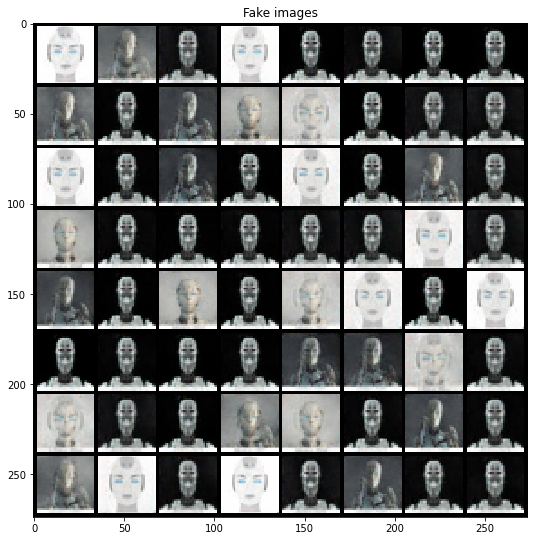

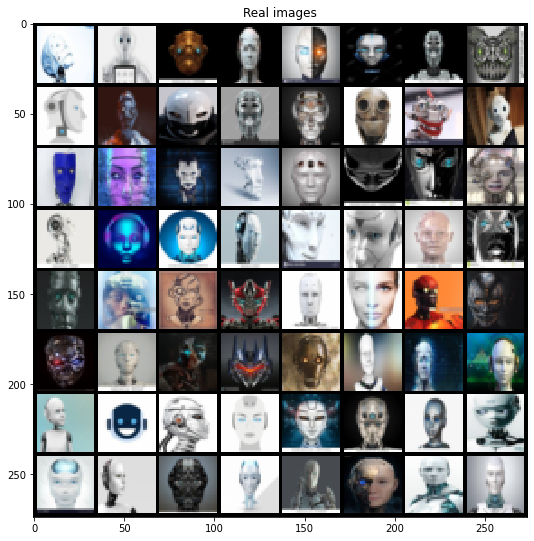

In [6]:

z = torch.randn((64, 100, 1, 1)).to(device)
out = gen(z)
out_fake = torchvision.utils.make_grid(out, normalize=True)
out_fake = out_fake.cpu().detach()

import matplotlib.pyplot as plt
np_fake_img = out_fake.permute(1,2,0)
fig1 = plt.figure(figsize=(20,20)) # create a 5 x 5 figure 
ax1 = fig1.add_subplot(211)
ax1.imshow(np_fake_img, interpolation='none')
ax1.set_title('Fake images')


img_loder = DataLoader(dataset, batch_size=64, shuffle=True)
real_imgs, _ = next(iter(img_loder))
#real_imgs.permute(1,2,0)
real_imgs_grid = torchvision.utils.make_grid(real_imgs, normalize=True)
np_real_imgs = real_imgs_grid.permute(1,2,0)
fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(212)
ax2.imshow(np_real_imgs, interpolation='none')
ax2.set_title('Real images')

plt.show()

In [56]:
torch.save(gen.state_dict(), 'gen_1.pt')
torch.save(disc.state_dict(),'disc_1.pt')